In [99]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'image.cmap': 'viridis'})
%matplotlib inline

# Logistic Regression Loglikelihood Example

In this notebook, I explicitely demonstrate the maximum likelihood principle using logistic regression on simulated data.

## generate synthetic dataset

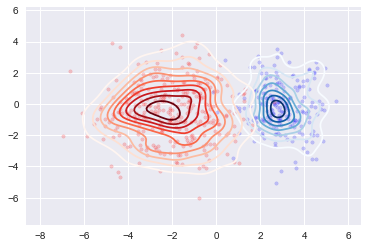

In [100]:
n_points_class1 = 200
n_points_class2 = 300
n_points = n_points_class1 + n_points_class2

predictors_class1 = np.random.multivariate_normal([3, 0], [[1, 0], [0, 2]], size=n_points_class1)
targets_class1 = np.zeros(n_points_class1, dtype=int)
predictors_class2 = np.random.multivariate_normal([-2, -0.5], [[3, 0],[0, 3]], size=n_points_class2)
targets_class2 = np.ones(n_points_class2, dtype=int)

X = np.concatenate([predictors_class1, predictors_class2])
y = np.concatenate([targets_class1, targets_class2])

i_shuffle = np.random.permutation(np.arange(n_points, dtype=int))
X = X[i_shuffle]
y = y[i_shuffle]

fig, ax = plt.subplots()
sns.kdeplot(data=X[y==0, 0], data2=X[y==0, 1], ax=ax, cmap='Blues')
ax.scatter(X[y==0, 0], X[y==0, 1], c='blue', marker='.', alpha=0.2)
sns.kdeplot(data=X[y==1, 0], data2=X[y==1, 1], ax=ax, cmap='Reds')
ax.scatter(X[y==1, 0], X[y==1, 1], c='red', marker='.', alpha=0.2);

## prepare a generalized linear model

a generalized linear model transforms the linear model with a monotone *link* function

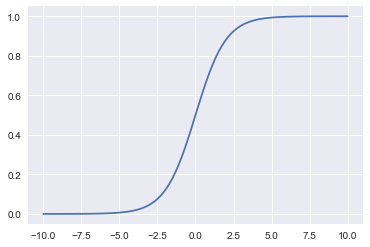

In [101]:
def link_function(scores, method='sigmoid'):
    if method == 'sigmoid':
        return 1/(1 + np.exp(-scores))
    else:
        raise NotImplementedError
        
plt.figure()
x = np.linspace(-10, 10, 100)
plt.plot(x, link_function(x));

## parameter grid search for maximum loglikelihood

We now define the log-likelihood of observations with respect to the model and compute it for a range of coefficients. The coefficients determine the *direction* of the linear function before it is transformed by the link_function.

/home/matthias/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/home/matthias/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in multiply


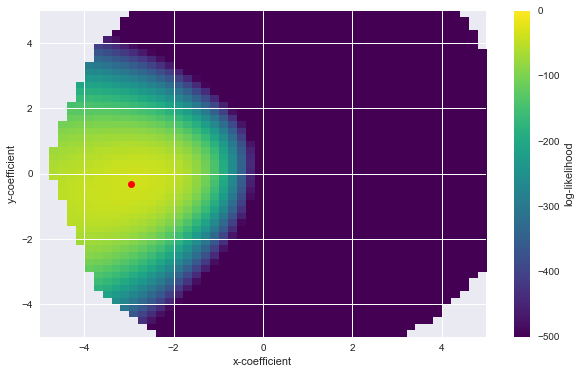

In [102]:
def log_likelihood(b0, b1, b2, X, y):
    scores = b0 + b1 * X[:, 0] + b2 * X[:, 1]
    P = link_function(scores)
    l = np.sum(y * np.log(P) + (1 - y) * np.log(1 - P))
    return l

b0_1d = np.linspace(-5, 5, 50)
b1_1d = np.linspace(-5, 5, 50)
b2_1d = np.linspace(-5, 5, 50)
b0grid, b1grid, b2grid = np.meshgrid(b0_1d, b1_1d, b2_1d, indexing='ij')
loglikelihood_gridsearch = np.array([log_likelihood(b0, b1, b2, X, y) for b0, b1, b2
                              in zip(b0grid.flatten(), b1grid.flatten(), b2grid.flatten())])
loglikelihood_gridsearch[~np.isfinite(loglikelihood_gridsearch)] = np.nanmin(loglikelihood_gridsearch)
loglikelihood_gridsearch = loglikelihood_gridsearch.reshape(b0grid.shape)

i0, i1, i2 = np.unravel_index(np.nanargmax(loglikelihood_gridsearch), loglikelihood_gridsearch.shape)
b0_max_likelihood = b0grid[i0, i1, i2]
b1_max_likelihood = b1grid[i0, i1, i2]
b2_max_likelihood = b2grid[i0, i1, i2]

fig, ax = plt.subplots(figsize=(10, 6))
norm_loglikelihood = plt.Normalize(-500, 0)
im = ax.imshow(loglikelihood_gridsearch[i0].T, aspect='auto', origin='lower', norm=norm_loglikelihood,
               extent=(b1[0], b1[-1], b2[0], b2[-1]))
ax.plot(b1_max_likelihood, b2_max_likelihood, 'o', c='r')
cb = fig.colorbar(im, label='log-likelihood')
ax.set(xlabel='x-coefficient', ylabel='y-coefficient');

Let's plot the regression function that was selected

[(-10, 10), (-10, 10)]

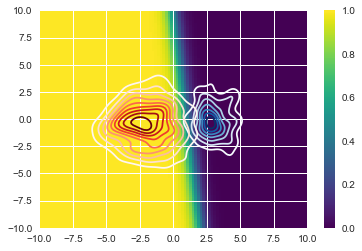

In [103]:
x1d = y1d = np.linspace(-10, 10, 100)
xgrid, ygrid = np.meshgrid(x1d, y1d, indexing='ij')
scores = b0_max_likelihood + b1_max_likelihood * xgrid + b2_max_likelihood * ygrid
regression_function = link_function(scores)

fig, ax = plt.subplots()
sns.kdeplot(data=X[y==0, 0], data2=X[y==0, 1], ax=ax, cmap='Blues')
sns.kdeplot(data=X[y==1, 0], data2=X[y==1, 1], ax=ax, cmap='Reds')
im = ax.imshow(regression_function.T, origin='lower', aspect='auto',
               extent=(x1d[0], x1d[-1], y1d[0], y1d[-1]))
plt.colorbar(im)

ax.set(xlim=(-10, 10), ylim=(-10, 10))

the regresion function nicely separates the two classes from each other.

## Quadratic Taylor approximation of log-likelihood

We now want to use Newtons method to determine the optimum of the maximum likelihood function. To this end, we compute the first and second derivatives of the likelihood function and express it as a second order Taylor series:

\begin{align}
    P &= \frac{1}{1 + e^{-\beta^T X}}\\
    \frac{\partial P}{\partial \beta} &= \frac{X e^{\beta^T X}}{1 + e^(-\beta^T X)^2} = -X P (1-P)
\end{align}

With this information, we can compute the first and second derivative of the loglikelihood that we need for a Taylor expansion:

\begin{align}
  l(\beta) &= \sum_i^N y_i \log{(P_i)} + (1 - y_i) \log{(1 - P_i)}\\
  \frac{\partial l}{\partial \beta} &= \sum_i^N X_i(y_i - P_i)\\
  \frac{\partial^2 l}{\partial \beta^T \partial \beta} &= -\sum_i^N X_i^T P_i (1-P_i) X_i
\end{align}

The Taylor series looks like:

\begin{align}
    l(\beta) \approx l_0 + \frac{\partial l}{\partial \beta} \Delta\beta + \frac{\partial^2 l}{2\partial \beta^T \partial \beta} \Delta \beta^2
\end{align}

This is what we are going to implement in the following cell ...

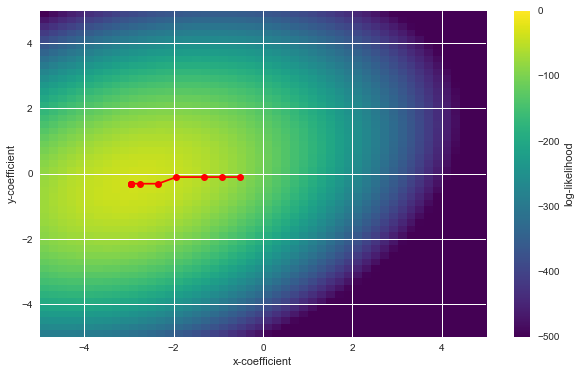

In [104]:
def log_likelihood_taylor(X, y, delta_beta, beta_0=np.array([0, 0, 0])):
    # add ones to X for the intercept
    X_intercept = np.concatenate([np.ones(n_points)[:, None], X], axis=1)

    # probabilities for the initial coefficients beta_0:
    scores = np.dot(X_intercept, beta_0)
    P = link_function(scores)

    # first and second derivatives of the log likelihood at the point of the initial conditions:
    l0 = np.sum(y * np.log(P) + (1 - y) * np.log(1 - P))
    dl_dbeta = np.dot(X_intercept.T, (y - P))
    ddl_dbetadbeta = -np.einsum('ij,i,il->jl', X_intercept, P * (1-P), X_intercept)
    
    # Taylor approximation of loglikelihood for the input points:
    # delta_beta is a matrix with shape [npoints, ncoeffs]
    corr1 = np.einsum('i,ji', dl_dbeta, delta_beta)
    corr2 = 0.5 * np.einsum('jk,kl,jl->j', delta_beta, ddl_dbetadbeta, delta_beta)
    l = l0 + corr1 + corr2
    return l
    
# now compute and plot the function
beta_grid = np.array([b0grid.flatten(), b1grid.flatten(), b2grid.flatten()]).T

beta_new = np.array([0, 0, 0])
beta_path = []
n_iterations = 10
for iteration in range(n_iterations):    
    delta_beta = beta_grid - beta_new
    loglikelihood_taylor = log_likelihood_taylor(X, y, delta_beta, beta_0=beta_new).reshape(b0grid.shape)
    
    imax = np.unravel_index(np.nanargmax(loglikelihood_taylor), loglikelihood_taylor.shape)
    beta_new = [b0grid[imax], b1grid[imax], b2grid[imax]]
    beta_path.append(beta_new)
beta_path = np.array(beta_path)

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(loglikelihood_taylor[i0].T, aspect='auto', origin='lower', norm=norm_loglikelihood,
               extent=(b1[0], b1[-1], b2[0], b2[-1]))
ax.plot(beta_path[:, 1], beta_path[:, 2], '-o', c='r')
cb = fig.colorbar(im, label='log-likelihood')
ax.set(xlabel='x-coefficient', ylabel='y-coefficient');

[(-10, 10), (-10, 10)]

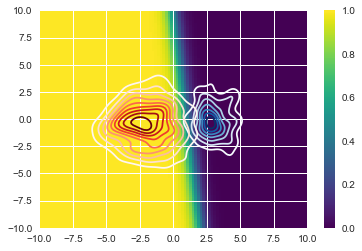

In [105]:
x1d = y1d = np.linspace(-10, 10, 100)
xgrid, ygrid = np.meshgrid(x1d, y1d, indexing='ij')
scores = beta_path[-1, 0] + beta_path[-1, 1] * xgrid + beta_path[-1, 2] * ygrid
regression_function = link_function(scores)

fig, ax = plt.subplots()
sns.kdeplot(data=X[y==0, 0], data2=X[y==0, 1], ax=ax, cmap='Blues')
sns.kdeplot(data=X[y==1, 0], data2=X[y==1, 1], ax=ax, cmap='Reds')
im = ax.imshow(regression_function.T, origin='lower', aspect='auto',
               extent=(x1d[0], x1d[-1], y1d[0], y1d[-1]))
plt.colorbar(im)

ax.set(xlim=(-10, 10), ylim=(-10, 10))

## differences between taylor and grid-search

The fit is very good around the maximum likelihood point.

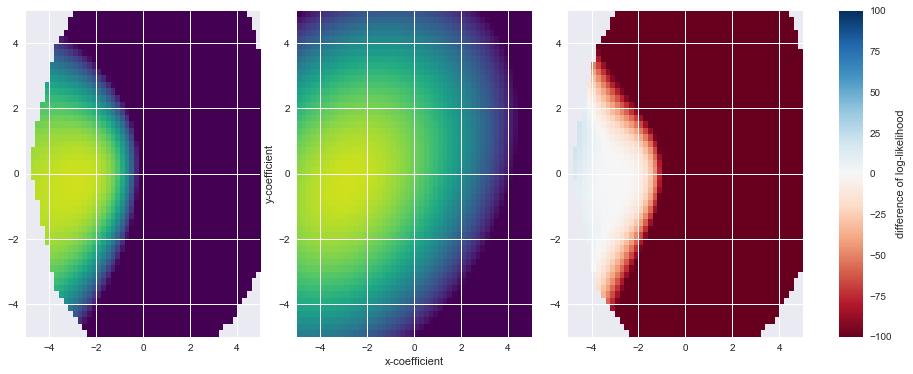

In [106]:
fig, (col1, col2, col3, cax) = plt.subplots(1, 4, figsize=(15, 6),
                                            gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})
im = col1.imshow(loglikelihood_gridsearch[i0].T, aspect='auto', origin='lower',
                 norm=norm_loglikelihood, extent=(b1[0], b1[-1], b2[0], b2[-1]))
im = col2.imshow(loglikelihood_taylor[i0].T, aspect='auto', origin='lower',
                 norm=norm_loglikelihood, extent=(b1[0], b1[-1], b2[0], b2[-1]))

error = loglikelihood_gridsearch[i0] - loglikelihood_taylor[i0]
norm_error = plt.Normalize(-100, 100)
im = col3.imshow(error.T, aspect='auto', origin='lower', norm=norm_error,
                 extent=(b1[0], b1[-1], b2[0], b2[-1]), cmap='RdBu')
cb = fig.colorbar(im, cax=cax, label='difference of log-likelihood')
col2.set(xlabel='x-coefficient', ylabel='y-coefficient');

## parameter significance analysis (LR Test for fully specified data distribution)
(*work in progress*)

For the first analysis, we test for the **exclusion of a single parameter** (i.e. Ward test). To this end, we set one of the parameters to zero, and check how the log-likelihood changes. The difference of loglikelihood can be translated in a ratio of probabilities: How much more likely is it to observe the datapoints with the maximum likelihood model, than with a model with less coefficients.

In [120]:
from scipy.stats import chi2

ibeta_null = [np.argmin(np.abs(grid)) for grid in [b0_1d, b1_1d, b2_1d]]

beta_max = beta_path[-1]
ibeta_max = [np.argmin(np.abs(bi_max - grid)) for bi_max, grid
             in zip(beta_max, [b0_1d, b1_1d, b2_1d])]

print('-- maximum likelihood taylor --:', end=" ")
max_loglikelihood = loglikelihood_taylor[ibeta_max[0], ibeta_max[1], ibeta_max[2]]
print(max_loglikelihood)
for inull in range(len(ibeta_null)):
    print('null hypothesis {}:'.format(inull))
    index = list(ibeta_max)
    index[inull] = ibeta_null[inull]
    null_loglikelihood = loglikelihood_taylor[index[0], index[1], index[2]]
    loglikelihood_reduction = max_loglikelihood - null_loglikelihood
    print('loglikelihood reduction:', loglikelihood_reduction)
    print('p-value:', 1 - chi2.cdf(3, loglikelihood_reduction))
    
print('-- maximum likelihood gridsearch --:', end=" ")
print(loglikelihood_gridsearch[ibeta_max[0], ibeta_max[1], ibeta_max[2]])
for inull in range(len(ibeta_null)):
    print('null hypothesis {}:'.format(inull), end=" ")
    index = list(ibeta_max)
    index[inull] = ibeta_null[inull]
    null_loglikelihood = loglikelihood_taylor[index[0], index[1], index[2]]
    loglikelihood_reduction = max_loglikelihood - null_loglikelihood
    print('loglikelihood reduction:', loglikelihood_reduction)
    print('p-value:', 1 - chi2.cdf(3, loglikelihood_reduction))

-- maximum likelihood taylor --: -36.5109164878
null hypothesis 0:
loglikelihood reduction: 47.0390438457
p-value: 1.0
null hypothesis 1:
loglikelihood reduction: 73.6460917464
p-value: 1.0
null hypothesis 2:
loglikelihood reduction: 0.50689558994
p-value: 0.0339946852665
-- maximum likelihood gridsearch --: -36.5109164878
null hypothesis 0: loglikelihood reduction: 47.0390438457
p-value: 1.0
null hypothesis 1: loglikelihood reduction: 73.6460917464
p-value: 1.0
null hypothesis 2: loglikelihood reduction: 0.50689558994
p-value: 0.0339946852665


# Coefficient standard error from the taylor expansion

In [119]:
X_intercept = np.concatenate([np.ones(n_points)[:, None], X], axis=1)

scores = np.dot(X_intercept, beta_max)
P = link_function(scores)

covariance = np.linalg.inv(np.einsum('ij,i,il->jl', X_intercept, P * (1-P), X_intercept))
stds = np.sqrt(np.diag(covariance))
print('z-scores:', beta_max/stds)
print(1-chi2.cdf(2, beta_max/stds))

z-scores: [ 5.37366643 -7.23685752 -1.45140068]
[ 0.87988364         nan         nan]
